In [1]:
!pip install wilds
!pip install SciencePlots

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_

Generating Relative License Plot (Smoothed with Splines)...
Bootstrapping 100 random samples (30 runs)...
Saved to waterbirds_relative_license_smooth.pdf


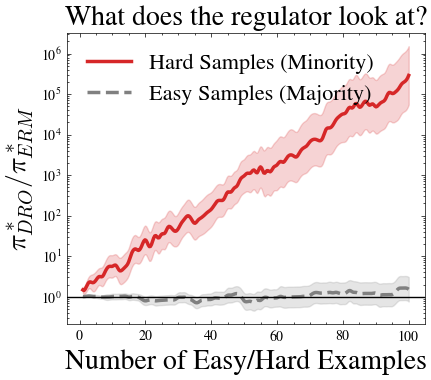

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.interpolate import make_interp_spline
plt.style.use(['science','no-latex'])

def plot_relative_license_smooth():
    print("Generating Relative License Plot (Smoothed with Splines)...")
    
    # --- 1. Load Data ---
    try:
        data_bad = torch.load('waterbirds_erm_results.pt')
        data_good = torch.load('waterbirds_group_dro_results.pt')
    except FileNotFoundError:
        print("Error: Files not found. Please run the training script first.")
        return

    # Extract Data
    logits_erm = data_bad['logits']
    logits_dro = data_good['logits']
    metadata = data_bad['metadata']
    y_true = metadata[:, 1]
    background = metadata[:, 0]
    
    # Identify subgroups
    is_hard = (background != y_true).numpy()
    
    # Calculate Probabilities
    q_erm = F.softmax(logits_erm, dim=1).gather(1, y_true.view(-1,1)).squeeze()
    q_dro = F.softmax(logits_dro, dim=1).gather(1, y_true.view(-1,1)).squeeze()
    
    # Calculate Log-Ratios (log(DRO/ERM))
    log_ratios = torch.log(q_dro / (q_erm + 1e-9)).numpy()
    
    ratios_majority = log_ratios[~is_hard]
    ratios_minority = log_ratios[is_hard]

    # --- 2. Bootstrap Function ---
    def get_bootstrap_window_se(data_stream, n_bootstraps=1000, window_size=100):
        n_available = len(data_stream)
        trajectories = []
        np.random.seed(42) # For reproducibility
        
        for _ in range(n_bootstraps):
            indices = np.random.randint(0, n_available, size=window_size)
            traj = np.cumsum(data_stream[indices])
            trajectories.append(traj)
            
        trajectories = np.array(trajectories)
        
        mean_traj = np.mean(trajectories, axis=0)
        std_traj = np.std(trajectories, axis=0)
        se_traj = std_traj / np.sqrt(n_bootstraps)
        
        return mean_traj, se_traj

    # Run Bootstrap for 100 samples
    n_plot = 100
    n_boot = 30 # Number of bootstrap iterations
    
    print(f"Bootstrapping {n_plot} random samples ({n_boot} runs)...")
    mean_log_maj, se_log_maj = get_bootstrap_window_se(ratios_majority, n_bootstraps=n_boot, window_size=n_plot)
    mean_log_min, se_log_min = get_bootstrap_window_se(ratios_minority, n_bootstraps=n_boot, window_size=n_plot)

    # Convert to Linear Space
    y_maj = np.exp(mean_log_maj)
    y_maj_lower = np.exp(mean_log_maj - se_log_maj)
    y_maj_upper = np.exp(mean_log_maj + se_log_maj)
    
    y_min = np.exp(mean_log_min)
    y_min_lower = np.exp(mean_log_min - se_log_min)
    y_min_upper = np.exp(mean_log_min + se_log_min)

    # --- 3. Spline Smoothing Helper ---
    def smooth_curve(x, y, n_points=300):
        # Create a new X-axis with more points
        x_new = np.linspace(x.min(), x.max(), n_points)
        # B-spline interpolation (k=3 for cubic)
        spl = make_interp_spline(x, y, k=3)
        y_smooth = spl(x_new)
        # Prevent smoothing artifacts from going below 0 (for linear scale)
        # or creating weird dips. Since we are in >0 space, clipping helps safety.
        y_smooth = np.maximum(y_smooth, 1e-9) 
        return x_new, y_smooth

    # Generate Smooth Curves
    x_axis = np.arange(1, n_plot + 1)
    
    x_smooth, y_min_smooth = smooth_curve(x_axis, y_min)
    _, y_min_lower_smooth = smooth_curve(x_axis, y_min_lower)
    _, y_min_upper_smooth = smooth_curve(x_axis, y_min_upper)
    
    x_smooth, y_maj_smooth = smooth_curve(x_axis, y_maj)
    _, y_maj_lower_smooth = smooth_curve(x_axis, y_maj_lower)
    _, y_maj_upper_smooth = smooth_curve(x_axis, y_maj_upper)

    # --- 4. Plotting ---
    plt.figure(figsize=(4.5, 4))
    
    # Plot Minority (Hard)
    plt.plot(x_smooth, y_min_smooth, color='#D62728', linewidth=2.5, label='Hard Samples (Minority)')
    plt.fill_between(x_smooth, y_min_lower_smooth, y_min_upper_smooth, color='#D62728', alpha=0.2)
    
    # Plot Majority (Easy)
    plt.plot(x_smooth, y_maj_smooth, color='gray', linewidth=2.5, linestyle='--', label='Easy Samples (Majority)')
    plt.fill_between(x_smooth, y_maj_lower_smooth, y_maj_upper_smooth, color='gray', alpha=0.2)
    
    # Reference Line (Break Even)
    plt.axhline(1.0, color='black', linewidth=1)
    
    # Logarithmic Scale
    plt.yscale('log')
    
    plt.xlabel("Number of Easy/Hard Examples", fontsize=20)
    plt.ylabel(r"$\pi^*_{DRO} / \pi^*_{ERM}$", fontsize=20)
    
    plt.legend(loc='upper left', fontsize=16)
    plt.title("What does the regulator look at?",fontsize=20)
    plt.tight_layout()
    plt.savefig('waterbirds_relative_license_smooth.pdf')
    print("Saved to waterbirds_relative_license_smooth.pdf")

if __name__ == "__main__":
    plot_relative_license_smooth()

In [3]:
import torch

def check_4group_accuracy():
    print("Loading model outputs...")
    try:
        data_bad = torch.load('waterbirds_erm_results.pt')
        data_good = torch.load('waterbirds_group_dro_results.pt')
    except FileNotFoundError:
        print("Error: Files not found. Run training script first.")
        return

    def print_breakdown(name, data):
        logits = data['logits']
        metadata = data['metadata'] # [background, label]
        
        # Extract columns
        background = metadata[:, 0]
        y_true = metadata[:, 1]
        preds = logits.argmax(dim=1)
        correct = (preds == y_true)

        print(f"\n=== {name} Breakdown ===")
        
        # Define the 4 Groups explicitly
        # Group 0: Landbird (0) on Land (0)
        mask_0 = (y_true == 0) & (background == 0)
        # Group 1: Landbird (0) on Water (1)
        mask_1 = (y_true == 0) & (background == 1)
        # Group 2: Waterbird (1) on Land (0)
        mask_2 = (y_true == 1) & (background == 0)
        # Group 3: Waterbird (1) on Water (1)
        mask_3 = (y_true == 1) & (background == 1)
        
        groups = [
            ("Landbird on Land (Majority)", mask_0),
            ("Landbird on Water (Minority)", mask_1),
            ("Waterbird on Land (Minority)", mask_2),
            ("Waterbird on Water (Majority)", mask_3)
        ]
        
        for group_name, mask in groups:
            if mask.sum() == 0:
                print(f"{group_name}: No samples")
                continue
                
            acc = correct[mask].float().mean().item() * 100
            count = mask.sum().item()
            print(f"{group_name:30} | Accuracy: {acc:5.2f}% (n={count})")

    print_breakdown("ERM (Bad Agent)", data_bad)
    print_breakdown("Group DRO (Robust Agent)", data_good)

if __name__ == "__main__":
    check_4group_accuracy()

Loading model outputs...

=== ERM (Bad Agent) Breakdown ===
Landbird on Land (Majority)    | Accuracy: 99.60% (n=2255)
Landbird on Water (Minority)   | Accuracy: 77.29% (n=2255)
Waterbird on Land (Minority)   | Accuracy: 56.54% (n=642)
Waterbird on Water (Majority)  | Accuracy: 92.37% (n=642)

=== Group DRO (Robust Agent) Breakdown ===
Landbird on Land (Majority)    | Accuracy: 99.33% (n=2255)
Landbird on Water (Minority)   | Accuracy: 87.01% (n=2255)
Waterbird on Land (Minority)   | Accuracy: 80.06% (n=642)
Waterbird on Water (Majority)  | Accuracy: 94.24% (n=642)


Loading model outputs...
Total Available Samples: 5794

Running 30 randomized audits (n=1500)...
Run 1/30 complete.
Run 2/30 complete.
Run 3/30 complete.
Run 4/30 complete.
Run 5/30 complete.
Run 6/30 complete.
Run 7/30 complete.
Run 8/30 complete.
Run 9/30 complete.
Run 10/30 complete.
Run 11/30 complete.
Run 12/30 complete.
Run 13/30 complete.
Run 14/30 complete.
Run 15/30 complete.
Run 16/30 complete.
Run 17/30 complete.
Run 18/30 complete.
Run 19/30 complete.
Run 20/30 complete.
Run 21/30 complete.
Run 22/30 complete.
Run 23/30 complete.
Run 24/30 complete.
Run 25/30 complete.
Run 26/30 complete.
Run 27/30 complete.
Run 28/30 complete.
Run 29/30 complete.
Run 30/30 complete.
Plot saved to waterbirds_final_plot.pdf


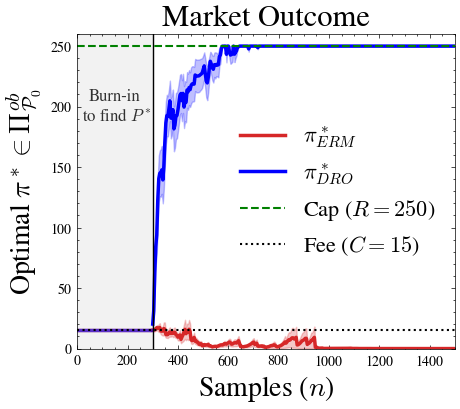

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.interpolate import make_interp_spline

# Try to use scienceplots, fallback if not installed
try:
    plt.style.use(['science', 'no-latex'])
except:
    print("Warning: scienceplots not found, using default style.")
    plt.style.use('default')

def load_and_audit(num_runs=10):
    print("Loading model outputs...")
    try:
        data_bad = torch.load('waterbirds_erm_results.pt')
        data_good = torch.load('waterbirds_group_dro_results.pt')
    except FileNotFoundError:
        print("Error: Could not find result files. Run training first.")
        return

    # Extract Data
    logits_null_orig = data_bad['logits']   
    logits_erm_orig = data_bad['logits']
    logits_dro_orig = data_good['logits']
    
    metadata = data_bad['metadata']
    background = metadata[:, 0]
    y_true_orig = metadata[:, 1]
    is_hard_orig = (background != y_true_orig)

    total_available = len(y_true_orig)
    print(f"Total Available Samples: {total_available}")
    
    # --- Configuration ---
    subset_size = 1500 # Sub-sample size for randomness
    results = {'ERM': [], 'Group DRO': []}

    print(f"\nRunning {num_runs} randomized audits (n={subset_size})...")
    
    for i in range(num_runs):
        seed = 42 + i
        torch.manual_seed(seed)
        
        # Random Sample without replacement
        perm = torch.randperm(total_available)[:subset_size]
        
        logits_null = logits_null_orig[perm]
        logits_erm = logits_erm_orig[perm]
        logits_dro = logits_dro_orig[perm]
        y_true = y_true_orig[perm]
        is_hard = is_hard_orig[perm]
        
        # Run Audit
        res_good = run_martingale_test(logits_null, logits_dro, y_true, is_hard)
        results['Group DRO'].append(res_good)
        
        res_bad = run_martingale_test(logits_null, logits_erm, y_true, is_hard)
        results['ERM'].append(res_bad)
        
        print(f"Run {i+1}/{num_runs} complete.")

    # Plot
    split_idx = int(subset_size * 0.2)
    plot_burn_in(results, subset_size, split_idx)

def run_martingale_test(logits_null, logits_user, y_true, is_hard):
    C = 15.0      
    R = 250.0     
    B = R / C    
    epsilon = 0.01 
    
    probs_null = F.softmax(logits_null, dim=1)
    probs_user = F.softmax(logits_user, dim=1)
    probs_user = (1 - epsilon) * probs_user + epsilon * 0.5

    n = len(y_true)
    split_idx = int(n * 0.2) 
    
    # Calibration
    p_null_cal = probs_null[:split_idx]
    p_user_cal = probs_user[:split_idx]
    y_cal = y_true[:split_idx]
    
    # Audit
    p_null_audit = probs_null[split_idx:]
    p_user_audit = probs_user[split_idx:]
    y_audit = y_true[split_idx:]

    # Optimize Alpha
    q_correct_cal = p_user_cal.gather(1, y_cal.view(-1, 1)).squeeze()
    null_correct_cal = p_null_cal.gather(1, y_cal.view(-1, 1)).squeeze()
    
    def objective(alpha):
        alpha = np.clip(alpha, 0.0, 1.0)
        p_mix = alpha * null_correct_cal + (1 - alpha) * 0.5
        ratios = q_correct_cal / (p_mix + 1e-9)
        max_r = torch.max(ratios).item()
        penalty = 0 if max_r <= B else 100 * (max_r - B)
        return -torch.mean(torch.log(p_mix + 1e-9)) + penalty

    res = minimize_scalar(objective, bounds=(0.5, 1.0), method='bounded')
    best_alpha = res.x

    # Run Bet
    q_audit = p_user_audit.gather(1, y_audit.view(-1, 1)).squeeze()
    null_audit = p_null_audit.gather(1, y_audit.view(-1, 1)).squeeze()
    p_star = best_alpha * null_audit + (1 - best_alpha) * 0.5
    
    # Calibration Phase: Wealth is constant C
    license_history = [C] * split_idx
    
    # Audit Phase: Wealth evolves
    curr_wealth = C
    for i in range(len(q_audit)):
        payoff = (q_audit[i] / p_star[i]).item()
        curr_wealth *= payoff
        if curr_wealth < 1e-4: curr_wealth = 0.0
        license_history.append(min(curr_wealth, R))
        
    return np.array(license_history)

def plot_burn_in(results, total_samples, split_idx):
    plt.figure(figsize=(4.8, 4))
    
    colors = {'Group DRO': 'blue', 'ERM': '#D62728'}
    labels = {'Group DRO': r"$\pi^*_{DRO}$", 'ERM': r"$\pi^*_{ERM}$"}
    
    def smooth_segment(y_segment, start_x, end_x, n_points=300):
        if len(y_segment) < 4: return np.arange(start_x, end_x), y_segment
        x_orig = np.arange(start_x, end_x)
        x_new = np.linspace(start_x, end_x - 1, n_points)
        try:
            spl = make_interp_spline(x_orig, y_segment, k=3)
            y_smooth = spl(x_new)
            y_smooth = np.clip(y_smooth, 0.0, 250.0)
            return x_new, y_smooth
        except:
            return x_orig, y_segment

    for name, histories in results.items():
        data = np.vstack(histories)
        
        mean_curve = np.mean(data, axis=0)
        std_curve = np.std(data, axis=0)
        se_curve = std_curve / np.sqrt(data.shape[0]) # Standard Error
        
        lower_bound = np.maximum(0, mean_curve - se_curve)
        upper_bound = np.minimum(250, mean_curve + se_curve)
        
        # 1. Plot Calibration (Flat)
        plt.plot(np.arange(0, split_idx), mean_curve[:split_idx], 
                 color=colors[name], linewidth=2.5, alpha=0.6)
        
        # 2. Plot Audit (Smoothed)
        y_aud = mean_curve[split_idx:]
        lower_aud = lower_bound[split_idx:]
        upper_aud = upper_bound[split_idx:]
        
        x_smooth, y_smooth = smooth_segment(y_aud, split_idx, total_samples)
        _, lower_smooth = smooth_segment(lower_aud, split_idx, total_samples)
        _, upper_smooth = smooth_segment(upper_aud, split_idx, total_samples)
        
        plt.plot(x_smooth, y_smooth, color=colors[name], linewidth=2.5, label=labels[name])
        plt.fill_between(x_smooth, lower_smooth, upper_smooth, color=colors[name], alpha=0.25)

    # --- Annotations & Reference Lines ---
    plt.axvline(split_idx, color='black', linestyle='-', linewidth=1.0)
    
    # Cap Line
    plt.axhline(250.0, color='green', linestyle='--', linewidth=1.5, label='Cap ($R=250$)')
    
    # Initial Wealth Line (Black Dotted)
    plt.axhline(15.0, color='black', linestyle=':', linewidth=1.5, label='Fee ($C=15$)')
    
    # Text Regions
    plt.text(split_idx * 0.5, 200, "Burn-in\n to find $P^*$", 
             ha='center', va='center', fontsize=12, color='black', alpha=0.8)

    # Shaded Calibration Zone
    plt.axvspan(0, split_idx, color='gray', alpha=0.1)

    plt.xlabel("Samples ($n$)", fontsize=20)
    plt.ylabel(r"Optimal $\pi^*\in\Pi^{ob}_{\mathcal{P}_0}$", fontsize=20)
    
    
    plt.xlim(0, total_samples)
    plt.ylim(0, 260)
    
    plt.legend(loc='center right', fontsize=16)
    plt.tight_layout()
    plt.title("Market Outcome", fontsize=22)
    filename = "waterbirds_final_plot.pdf"
    plt.savefig(filename, bbox_inches='tight')
    print(f"Plot saved to {filename}")

if __name__ == "__main__":
    load_and_audit(num_runs=30)